<a href="https://colab.research.google.com/github/LucaSamore/Stroke-Prediction-Analysis/blob/main/stroke_prediction_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predizione di ictus in base ai dati di un paziente
**Progetto di Programmazione di Applicazioni Data Intensive a.a 2022/23**

Luca Samorè

luca.samore@studio.unibo.it

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Introduzione
Nel presente progetto vengono analizzati vari modelli di classificazione per prevedere quanto è probabile che un paziente venga colpito da un ictus. Il dataset, ottenuto da [Kaggle](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset), contiene oltre 5000 record di pazienti, alcuni dei quali sono stati colpiti da tale evento neurologico. L’obiettivo, dunque, è quello di prevedere una variabile discreta binaria.


In [32]:
dataset = pd.read_csv('healthcare-dataset-stroke-data.csv', sep=',')

## Analisi delle feature

In [33]:
dataset.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


**Variabili categoriche**
- `gender`: sesso del paziente
  - "Male"
  - "Female"
  - "Other"
- `work_type`: tipologia di impiego del paziente
  - "children"
  - "Govt_jov"
  - "Never_worked"
  - "Private"
  - "Self-employed"
- `Residence_type`: tipologia di residenza del paziente
  - "Rural"
  - "Urban"
- `smoking_status`: stato di fumatore
  - "formerly smoked"
  - "never smoked"
  - "smokes"
  - "Unknown"
- `ever_married`: "Yes" se il paziente è mai stato sposato, "No" altrimenti
- `hypertension`: 1 se il paziente è affetto da ipertensione, 0 altrimenti
- `heart_disease`: 1 se il paziente ha complicanze cardiache, 0 altrimenti
- `stroke`: 1 se il paziente è stato colpito da ictus, 0 altrimenti

**Variabili numeriche**
- `id`: identificatore univoco del paziente
- `age`: età del paziente
- `avg_glucose_level`: livello medio di glucosio nel sangue
- `bmi`: indice di massa corporea

La variabile target è `stroke` che vale 1 se il paziente è stato colpito da ictus, 0 altrimenti.


In [34]:
dataset.info(memory_usage='deep');

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 1.8 MB


Siccome alcune variabili categoriche sono di tipo object (`gender`, `ever_married`, `work_type`, `Residence_type`, `smoking_status`), per consumare meno memoria, ricarichiamo il dataset modificando il loro tipo come categorico.

In [35]:
categorical_features = [
    'gender',
    'hypertension',
    'heart_disease',
    'ever_married',
    'work_type',
    'Residence_type',
    'smoking_status',
    'stroke',
]

In [36]:
dataset = pd.read_csv(
    'healthcare-dataset-stroke-data.csv',
    sep=',',
    dtype={c: 'category' for c in categorical_features}
)

In [37]:
dataset.info(memory_usage='deep');

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   id                 5110 non-null   int64   
 1   gender             5110 non-null   category
 2   age                5110 non-null   float64 
 3   hypertension       5110 non-null   category
 4   heart_disease      5110 non-null   category
 5   ever_married       5110 non-null   category
 6   work_type          5110 non-null   category
 7   Residence_type     5110 non-null   category
 8   avg_glucose_level  5110 non-null   float64 
 9   bmi                4909 non-null   float64 
 10  smoking_status     5110 non-null   category
 11  stroke             5110 non-null   category
dtypes: category(8), float64(3), int64(1)
memory usage: 201.9 KB


Notiamo che il consumo di memoria è stato ridotto significativamente.

La colonna `id` contiene un identificatore univoco per ogni paziente. Essa è irrilevante ai fini della predizione, perciò la possiamo eliminare o utilizzare come indice del dataframe. Procediamo con la seconda soluzione.

In [38]:
dataset.set_index('id', inplace=True)
dataset.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


## Analisi esplorativa e pulizia dei dati


Per ogni variabile numerica, visualizziamo alcune statistiche, come media, minimo, massimo, deviazione standard e percentili.

In [39]:
dataset.describe()

,age,avg_glucose_level,bmi
count,5110.000000,5110.000000,4909.000000
mean,43.226614,106.147677,28.893237
std,22.612647,45.283560,7.854067
min,0.080000,55.120000,10.300000
25%,25.000000,77.245000,23.500000
50%,45.000000,91.885000,28.100000
75%,61.000000,114.090000,33.100000
max,82.000000,271.740000,97.600000


Controlliamo se e quanto le due classi sono sbilanciate.

In [40]:
dataset['stroke'].value_counts()

0    4861
1     249
Name: stroke, dtype: int64

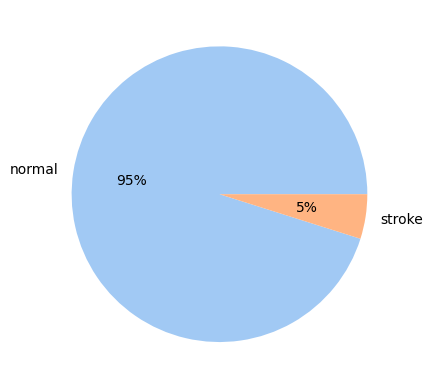

In [41]:
plt.pie(
    dataset['stroke'].value_counts(),
    labels=['normal', 'stroke'],
    colors=sns.color_palette('pastel'),
    autopct='%.0f%%'
);

Come potevamo aspettarci, le classi sono fortemente sbilanciate. Nella sezione successiva utilizzeremo delle tecniche apposite per affrontare questo problema.

Verifichiamo ora la presenza di valori nulli all’interno del dataset.

In [42]:
dataset.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

Notiamo che sono presenti 201 istanze in cui la feature `bmi` è NaN.

In [43]:
dataset[dataset['bmi'].isna()]['stroke'].value_counts()

0    161
1     40
Name: stroke, dtype: int64

Tra queste 201 istanze, 161 sono pazienti che non sono stati colpiti da ictus, mentre le restanti 40 invece lo sono. Per non sbilanciare ulteriormente le classi, invece di eliminare le 201 istanze, riempiamo i valore nulli con la media della colonna `bmi`.

In [44]:
dataset.fillna(dataset['bmi'].mean(), inplace=True)
dataset.isna().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

Andiamo a visualizzare la distribuzione delle variabili continue del dataset, distinguendo le due categorie di pazienti.

In [45]:
numeric_features = [
    'age',
    'avg_glucose_level',
    'bmi',
]

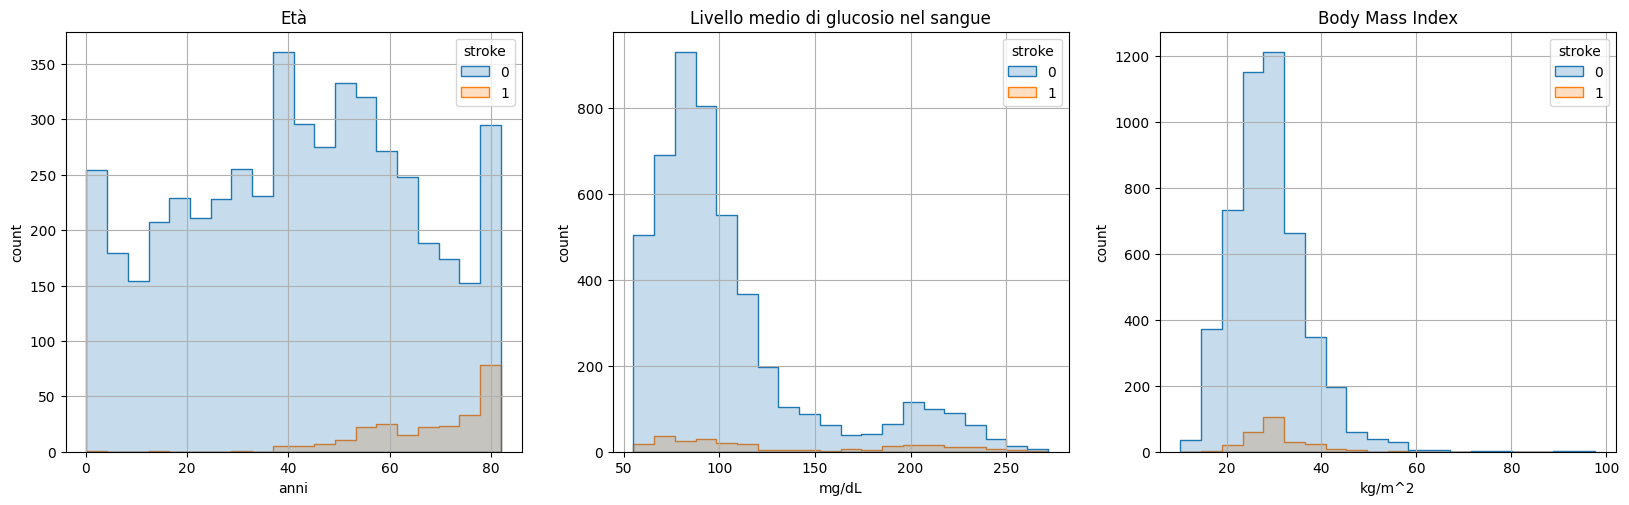

In [46]:
titles = [
    'Età',
    'Livello medio di glucosio nel sangue',
    'Body Mass Index',
]

xlabels = [
    'anni',
    'mg/dL',
    'kg/m^2',
]

plt.figure(figsize=(20, 12))

for i, feature in enumerate(numeric_features, start=1):
  plt.subplot(2, 3, i)
  plt.title(titles[i-1])
  sns.histplot(
    x=feature,
    hue='stroke',
    data=dataset,
    bins=20,
    element='step'
  )
  plt.grid()
  plt.ylabel('count')
  plt.xlabel(xlabels[i-1])

plt.show()

In generale, i pazienti che sono stati colpiti da ictus hanno un’età compresa tra i 40 e gli 80 anni, con la maggioranza dei pazienti colpiti intorno agli 80 anni.

Il livello di glucosio medio nel sangue si concentra per la maggior parte tra i 60 e i 120 $\frac{mg}{dL}$. Ma ci sono anche pazienti con un alto valore di glucosio, molti di questi colpiti da ictus.

La maggiornaza dei pazienti ha un indice di massa corporea tra i 20 e i 40 $\frac{kg}{m^2}$.

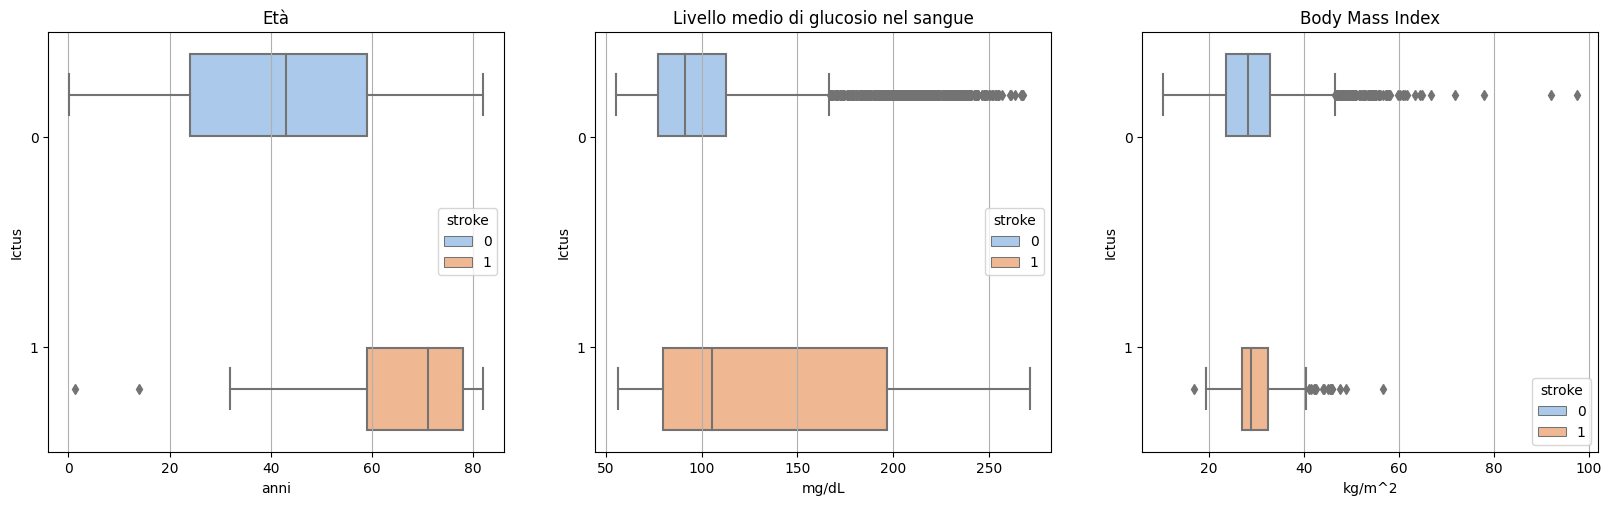

In [47]:
plt.figure(figsize=(20, 12))

for i, feature in enumerate(numeric_features, start=1):
  plt.subplot(2, 3, i)
  sns.boxplot(
    data=dataset,
    x=feature,
    y='stroke',
    hue='stroke',
    palette='pastel',
  )
  plt.title(titles[i-1])
  plt.xlabel(xlabels[i-1])
  plt.ylabel('Ictus')
  plt.grid(axis='x')

plt.show()

Notiamo che per le colonne `avg_glucose_level` e `bmi` sono presenti molti outliers.

Per quanto concerne l’indice glicemico, ipotizzando che le istanze con valore nell’intervallo 200-250 $\frac{mg}{dL}$ sono pazienti diabetici, decidiamo di mantenere le istanze. Per gli altri valori, cioè quelli intorno a 150 $\frac{mg}{dL}$, si ipotizza che siano relativi a misurazioni effettuate vicino ai pasti, più in generale a momenti in cui il paziente ha assunto una certa quantità di glucosio.

Per quanto riguarda l’indice di massa corporea, notiamo che sono presenti valori decisamente alti e altamente improbabili, in particolare quelli superiori ad 80. Decidiamo perciò di rimuovere tali istanze.

In [48]:
dataset.drop(dataset[dataset['bmi'] >= 60].index, inplace=True)
dataset['bmi'].describe()

count    5097.000000
mean       28.789649
std         7.404873
min        10.300000
25%        23.800000
50%        28.400000
75%        32.800000
max        59.700000
Name: bmi, dtype: float64

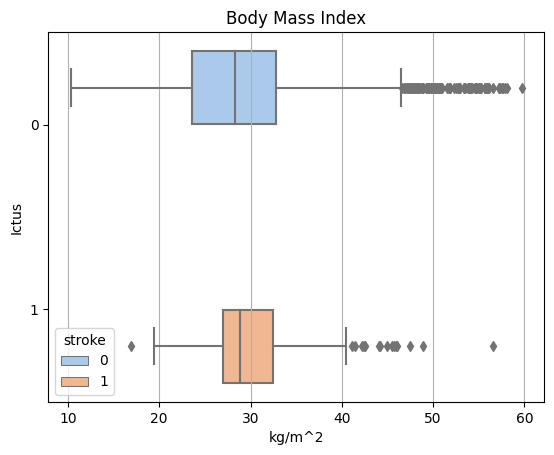

In [49]:
sns.boxplot(
  data=dataset,
  x='bmi',
  y='stroke',
  hue='stroke',
  palette='pastel',
)
plt.title('Body Mass Index')
plt.xlabel('kg/m^2')
plt.ylabel('Ictus')
plt.grid(axis='x')

In [50]:
categorical_features = [
    'gender',
    'hypertension',
    'heart_disease',
    'ever_married',
    'work_type',
    'Residence_type',
    'smoking_status',
]

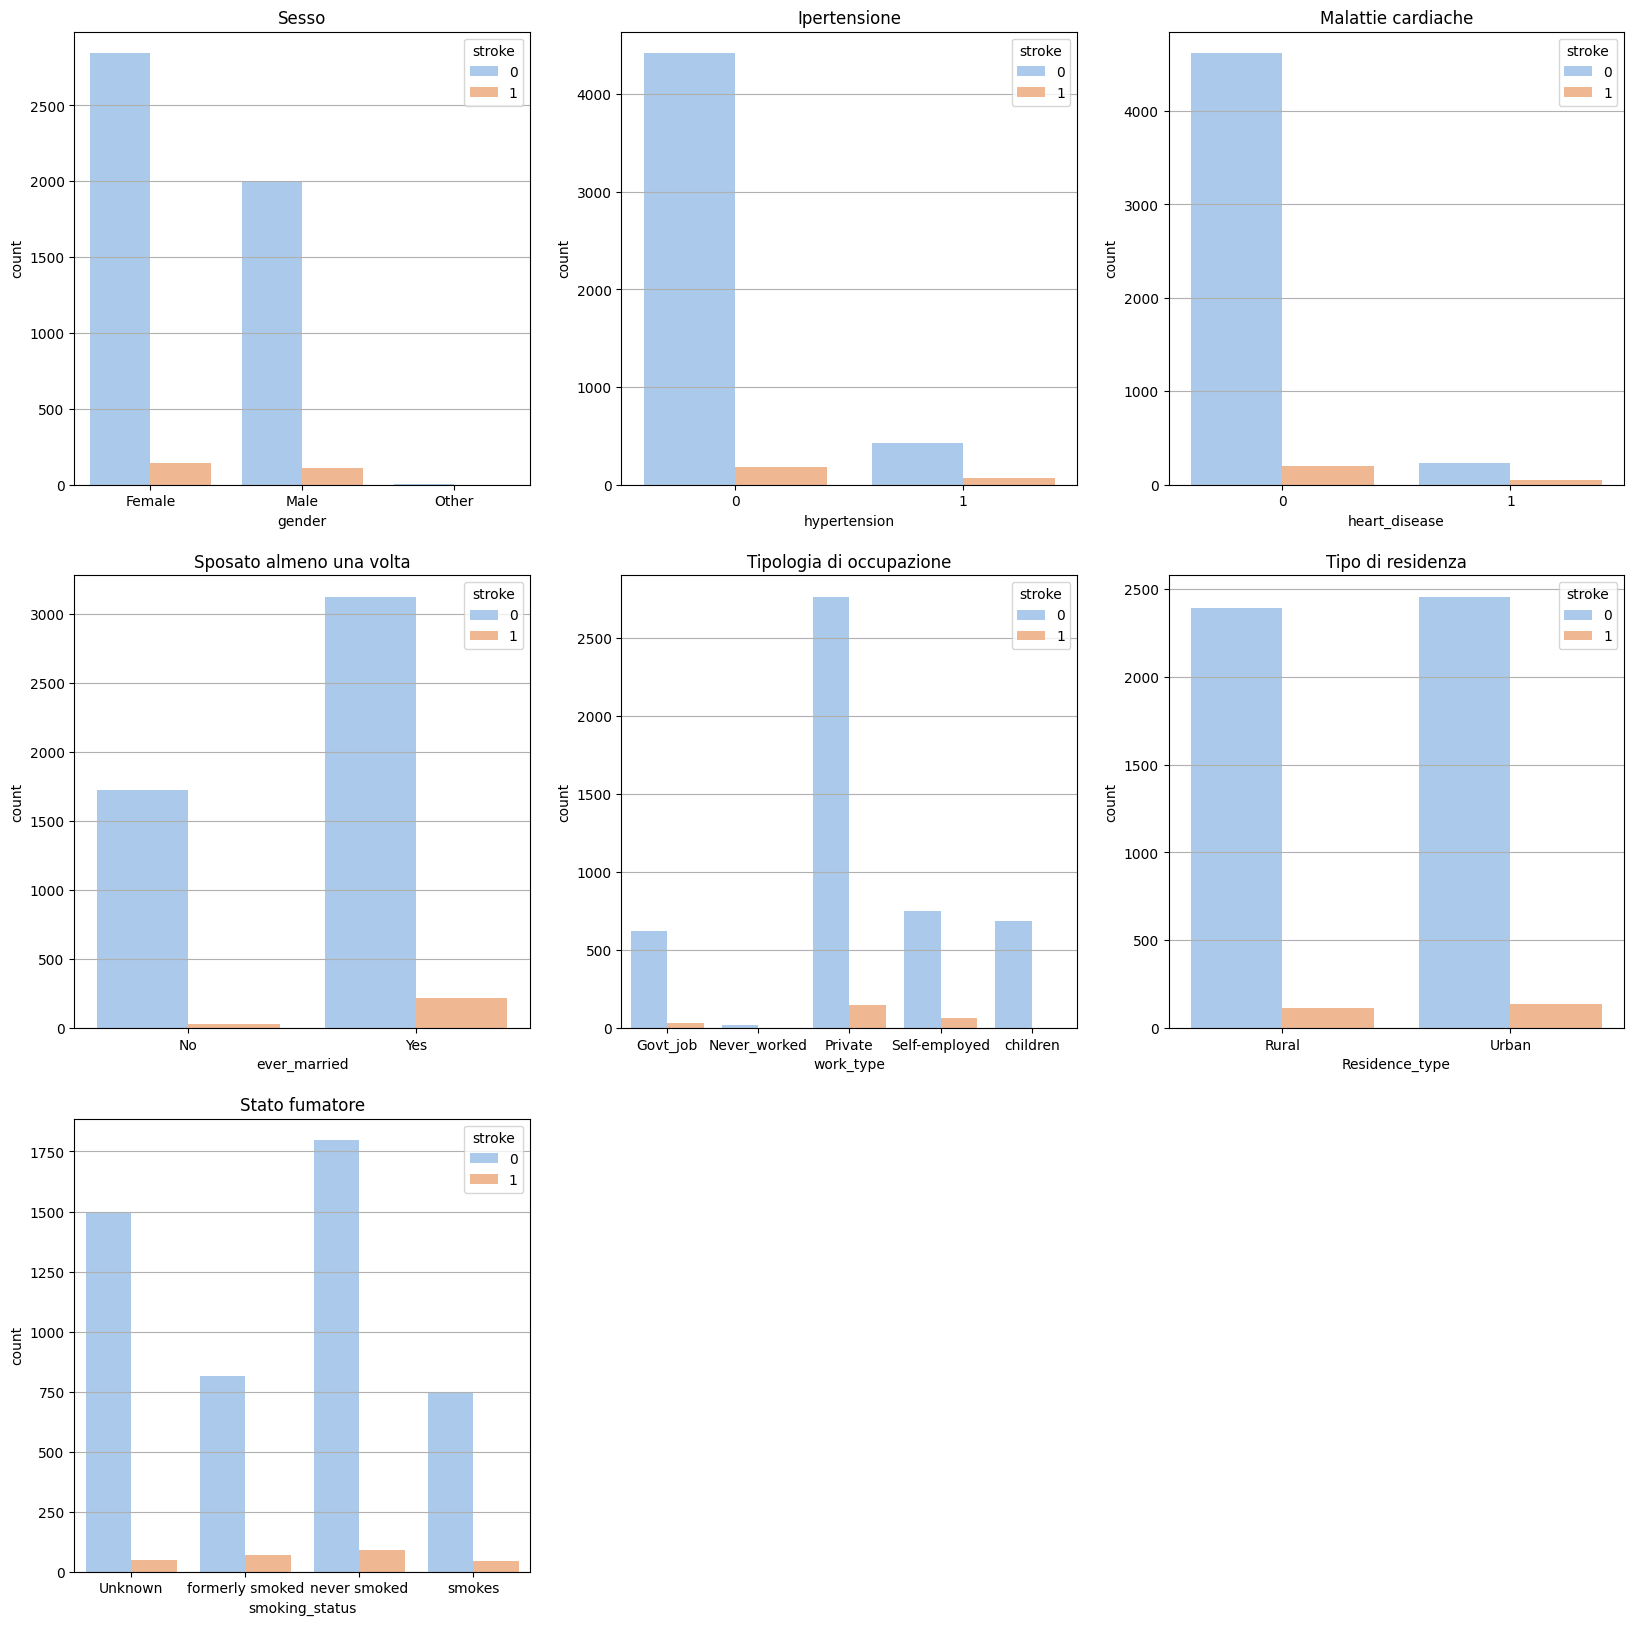

In [51]:
titles = [
    'Sesso',
    'Ipertensione',
    'Malattie cardiache',
    'Sposato almeno una volta',
    'Tipologia di occupazione',
    'Tipo di residenza',
    'Stato fumatore',
  ]

plt.figure(figsize=(20, 20))

for i, feature in enumerate(categorical_features, start=1):
  plt.subplot(3, 3, i)
  sns.countplot(
    data=dataset,
    x=feature,
    hue='stroke',
    palette='pastel',
  )
  plt.title(titles[i-1])
  plt.grid(axis='y')

plt.show()

Dal primo grafico notiamo che le donne sono leggermente meno soggette a ictus rispetto agli uomini. Pochissimi pazienti soffrono di ipertensione e di malattie cardiache. Circa due terzi dei pazienti presenti nel dataset si sono sposati almeno una volta. Quasi tutti i pazienti hanno un lavoro e sono tutti pressoché equamente distribuiti per quanto riguarda la loro residenza (urbana o rurale). Infine, è presente un elevato numero di pazienti di cui non si sa lo stato fumatore, ma ce ne sono tanti che non hanno mai fumato.

<Axes: >

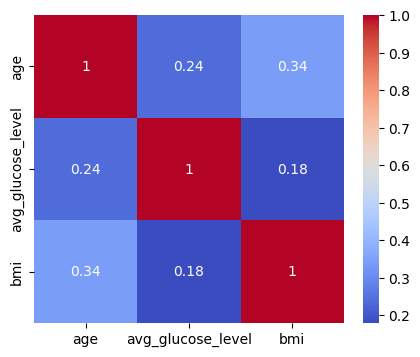

In [52]:
correlation_matrix = dataset.corr(method='pearson', numeric_only=True)
plt.figure(figsize=(5,4))
sns.heatmap(correlation_matrix, cmap="coolwarm", annot=True)

Dalla matrice di correlazione si osserva che la correlazione di Pearson tra le variabili numeriche è molto bassa. Possiamo dunque mantenere tutte queste variabili quando andremo ad addestrare il modello.